# Zaawansowane techniki Ensemble Learning w praktyce


### Komórka 2: Code (Import bibliotek i generowanie danych)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import fetch_covtype, load_wine

# Wczytanie danych COVERTYPE
print("Wczytywanie zbioru danych Covertype...")
covtype = fetch_covtype()
X, y = covtype.data, covtype.target
print("Zbiór danych wczytany.")

y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Kształt danych treningowych X:", X_train_scaled.shape)
print("Kształt danych treningowych y:", y_train.shape)

results_covtype_data = {}

Wczytywanie zbioru danych Covertype...
Zbiór danych wczytany.
Zbiór danych wczytany.
Kształt danych treningowych X: (464809, 54)
Kształt danych treningowych y: (464809,)
Kształt danych treningowych X: (464809, 54)
Kształt danych treningowych y: (464809,)


### Zadanie 1: Porównanie dokładności modeli: Random Forest, XGBoost i Stacking

In [43]:
# --- 1. Random Forest Classifier ---
print("Trenowanie Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)
results_covtype_data['Random Forest'] = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest F1-Score: {results_covtype_data['Random Forest']:.4f}")

# --- 2. XGBoost Classifier ---
print("\nTrenowanie XGBoost...")
xgb_clf = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
results_covtype_data['XGBoost'] = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"XGBoost F1-Score: {results_covtype_data['XGBoost']:.4f}")

# --- 3. Stacking Classifier ---
print("\nTrenowanie Stacking Classifier...")
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss'))
]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
stack_clf.fit(X_train_scaled, y_train)
y_pred_stack = stack_clf.predict(X_test_scaled)
results_covtype_data['Stacking'] = f1_score(y_test, y_pred_stack, average='weighted')
print(f"Stacking Classifier F1-Score: {results_covtype_data['Stacking']:.4f}")

Trenowanie Random Forest...
Random Forest F1-Score: 0.9530

Trenowanie XGBoost...
Random Forest F1-Score: 0.9530

Trenowanie XGBoost...
XGBoost F1-Score: 0.8674

Trenowanie Stacking Classifier...
XGBoost F1-Score: 0.8674

Trenowanie Stacking Classifier...
Stacking Classifier F1-Score: 0.9444
Stacking Classifier F1-Score: 0.9444


### Zadanie 2: Tuning hiperparametrów dla modelu XGBoost

In [ ]:
# --- Tuning XGBoost ---
print("\nTuning hiperparametrów XGBoost...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10], # Zmniejszono parametry dla szybszego działania
    'learning_rate': [0.1, 0.2]
}
xgb_for_tuning = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_for_tuning, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Najlepsze parametry dla XGBoost: {grid_search.best_params_}")
y_pred_xgb_tuned = grid_search.predict(X_test_scaled)
results_covtype_data['XGBoost (Tuned)'] = f1_score(y_test, y_pred_xgb_tuned, average='weighted')
print(f"XGBoost (po tuningu) F1-Score: {results_covtype_data['XGBoost (Tuned)']:.4f}")


Tuning hiperparametrów XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Najlepsze parametry dla XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Najlepsze parametry dla XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
XGBoost (po tuningu) F1-Score: 0.9589
XGBoost (po tuningu) F1-Score: 0.9589


### Zadanie 3: Wprowadzenie nowego modelu do zestawu stackingowego

In [ ]:
# --- Nowy Stacking ---
print("\nTrenowanie nowego modelu Stacking...")
estimators_new = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss')),
    ('dt', DecisionTreeClassifier(random_state=42))
]
stack_new = StackingClassifier(estimators=estimators_new, final_estimator=LogisticRegression(), n_jobs=-1)
stack_new.fit(X_train_scaled, y_train)
y_pred_stack_new = stack_new.predict(X_test_scaled)
results_covtype_data['Stacking (New)'] = f1_score(y_test, y_pred_stack_new, average='weighted')
print(f"Stacking (z Decision Tree) F1-Score: {results_covtype_data['Stacking (New)']:.4f}")


Trenowanie nowego modelu Stacking...
Stacking (z Decision Tree) F1-Score: 0.9541
Stacking (z Decision Tree) F1-Score: 0.9541


### Zadanie 4: Przetestowanie modeli na innym zbiorze danych (`Wine`)

In [46]:
# --- Testy na zbiorze Wine ---
print("\nTestowanie modeli na zbiorze Wine...")
wine = load_wine()
X_w, y_w = wine.data, wine.target
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size=0.2, random_state=42)

scaler_w = StandardScaler()
X_w_train_scaled = scaler_w.fit_transform(X_w_train)
X_w_test_scaled = scaler_w.transform(X_w_test)
results_wine_data = {}

# 1. Random Forest
rf_clf.fit(X_w_train_scaled, y_w_train)
y_w_pred_rf = rf_clf.predict(X_w_test_scaled)
results_wine_data['Random Forest'] = accuracy_score(y_w_test, y_w_pred_rf)
print(f"Random Forest (Wine) Accuracy: {results_wine_data['Random Forest']:.4f}")

# 2. XGBoost (z najlepszymi parametrami)
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_w_train_scaled, y_w_train)
y_w_pred_xgb = best_xgb.predict(X_w_test_scaled)
results_wine_data['XGBoost (Tuned)'] = accuracy_score(y_w_test, y_w_pred_xgb)
print(f"XGBoost (Tuned, Wine) Accuracy: {results_wine_data['XGBoost (Tuned)']:.4f}")

# 3. Stacking (z nowym modelem)
stack_new.fit(X_w_train_scaled, y_w_train)
y_w_pred_stack = stack_new.predict(X_w_test_scaled)
results_wine_data['Stacking (New)'] = accuracy_score(y_w_test, y_w_pred_stack)
print(f"Stacking (New, Wine) Accuracy: {results_wine_data['Stacking (New)']:.4f}")


Testowanie modeli na zbiorze Wine...
Random Forest (Wine) Accuracy: 1.0000
XGBoost (Tuned, Wine) Accuracy: 0.9444
Random Forest (Wine) Accuracy: 1.0000
XGBoost (Tuned, Wine) Accuracy: 0.9444
Stacking (New, Wine) Accuracy: 0.9722
Stacking (New, Wine) Accuracy: 0.9722


### Zadanie 5: Przedstawienie wyników w formie wykresu słupkowego

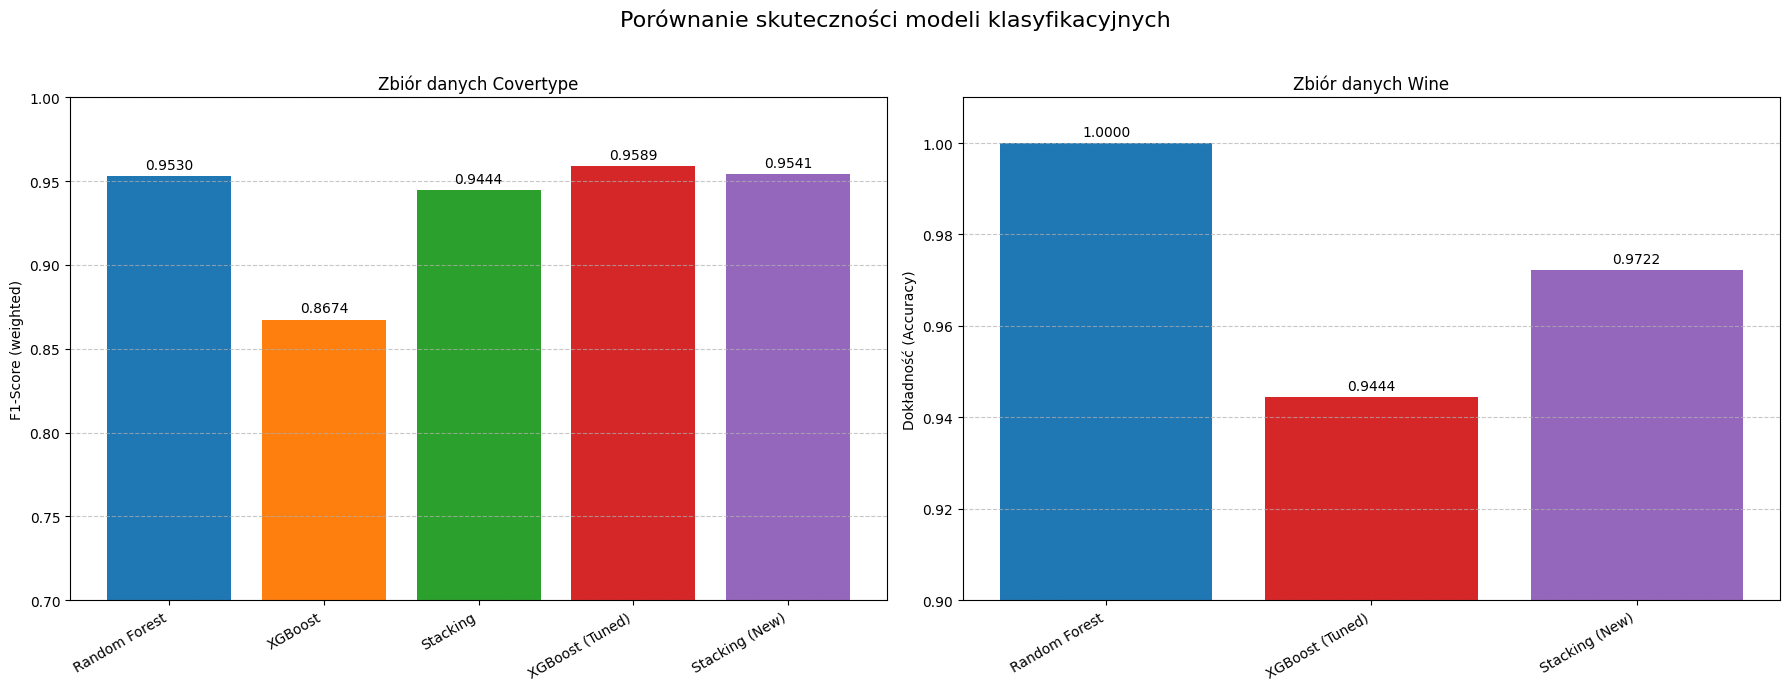

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Porównanie skuteczności modeli klasyfikacyjnych', fontsize=16)

# === WYKRES 1 ===
covtype_models = list(results_covtype_data.keys())
covtype_scores = list(results_covtype_data.values())
bars1 = axes[0].bar(covtype_models, covtype_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0].set_title('Zbiór danych Covertype')
axes[0].set_ylabel('F1-Score (weighted)')
axes[0].set_ylim(0.7, 1.0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
plt.setp(axes[0].get_xticklabels(), rotation=30, ha="right")
axes[0].bar_label(bars1, fmt='%.4f', padding=3)

# === WYKRES 2 ===
wine_models = list(results_wine_data.keys())
wine_scores = list(results_wine_data.values())
bars2 = axes[1].bar(wine_models, wine_scores, color=['#1f77b4', '#d62728', '#9467bd'])
axes[1].set_title('Zbiór danych Wine')
axes[1].set_ylabel('Dokładność (Accuracy)')
axes[1].set_ylim(0.9, 1.01)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha="right")
axes[1].bar_label(bars2, fmt='%.4f', padding=3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()